In [2]:
from sklearn import datasets
from sklearn.model_selection import train_test_split, GridSearchCV, RepeatedKFold
from sklearn.metrics import balanced_accuracy_score, precision_recall_curve, confusion_matrix, classification_report, f1_score
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.neural_network import MLPClassifier
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
#загрузка данных

file_list = ['learning_train.csv']
data_set = pd.concat([pd.read_csv(f) for f in file_list], ignore_index=True)
data_set

,DEPT,PS,PZ,GK,NGK,DS,LIT
0,600.0,0.721051,0.040846,0.139665,0.287053,0.009050,53
1,600.2,0.718286,0.036674,0.117318,0.283646,0.009050,53
2,600.4,0.715520,0.033349,0.108007,0.287053,0.009050,53
3,600.6,0.712755,0.027921,0.104904,0.300681,0.009050,53
4,600.8,0.709990,0.022509,0.096834,0.316865,0.011312,53
...,...,...,...,...,...,...,...
99629,1883.2,0.066815,0.028341,0.443899,0.198152,0.071856,9
99630,1883.4,0.065290,0.028341,0.445178,0.212874,0.065868,9
99631,1883.6,0.063340,0.028341,0.449117,0.218966,0.059880,9
99632,1883.8,0.060600,0.028107,0.446508,0.217104,0.065868,9


In [4]:
X = data_set[['PS', 'PZ', 'GK', 'NGK', 'DS']]
Y = data_set['LIT']

In [5]:
#Разбиваем набор данных на обучающую и тестовую выборку
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

In [6]:
# #Проведем предварительную обработку данных
# #MinMaxScaler сдвигает данные таким образом, что все признаки находились строго в диапазоне от 0 до 1
# scaler = MinMaxScaler()
#подгоняем scaler на обучающем наборе данных и масштабируем обучающую и тестовую выборку
X_train_scaled = X_train
X_test_scaled = X_test
print("Отмасштабированная обучающая выборка:\n{}".format(X_train_scaled[:5]))
print("\nОтмасштабированная тестовая выборка:\n{}".format(X_test_scaled[:5]))

Отмасштабированная обучающая выборка:
             PS        PZ        GK       NGK        DS
15247  0.852302  0.084180  0.042332  0.644784  0.031048
5735   0.328725  0.004156  0.510863  0.034072  0.092760
10841  0.254044  0.109079  0.290398  0.668828  0.016556
61290  0.308074  0.229627  0.071869  0.542086  0.008097
91710  0.398351  1.000000  0.022857  0.555404  0.012721

Отмасштабированная тестовая выборка:
             PS        PZ        GK       NGK        DS
2360   0.574577  0.180907  0.137803  0.638842  0.029412
56077  0.439883  0.178771  0.033813  0.307214  0.015015
8309   0.773443  0.037690  0.151966  0.538104  0.016556
36550  0.550315  0.079404  0.039057  0.617201  0.002198
53635  0.571212  0.095874  0.047515  0.314881  0.008453


In [7]:
#решетчатый поиск
mlp = MLPClassifier(max_iter=100000000, activation='logistic', solver='sgd', learning_rate='adaptive', random_state=42)
cvc = RepeatedKFold(n_splits=10, n_repeats=5, random_state=42)
#словарь параметров для перекрестной проверки
# param_grid = {'alpha': [0.0001, 0.001, 0.01, 0.1, 1], 'hidden_layer_sizes': [(40, ), (50, ), (60, ), (50, 60), (60, 50, 40)]}
param_grid = {'alpha': [0.0001], 'hidden_layer_sizes': [(40, )]}
#перекрестная проверка и подбор лучших параметров
grid_search = GridSearchCV(mlp, param_grid, cv=cvc, verbose=5, n_jobs=-1)


In [8]:
#обучение модели
grid_search.fit(X_train_scaled, y_train)

Fitting 50 folds for each of 1 candidates, totalling 50 fits


GridSearchCV(cv=RepeatedKFold(n_repeats=5, n_splits=10, random_state=42),
             estimator=MLPClassifier(activation='logistic',
                                     learning_rate='adaptive',
                                     max_iter=100000000, random_state=42,
                                     solver='sgd'),
             n_jobs=-1,
             param_grid={'alpha': [0.0001], 'hidden_layer_sizes': [(40,)]},
             verbose=5)

In [15]:
print("Наилучшие значения параметров: {}".format(grid_search.best_params_))
print("Наилучшее значение кросс-валидационной сетки: {:.2f}".format(grid_search.best_score_))

Наилучшие значения параметров: {'alpha': 0.0001, 'hidden_layer_sizes': (40,)}
Наилучшее значение кросс-валидационной сетки: 0.61


In [16]:
#запоминаем лучшее параметры модели, подобранные на предыдущем шаге
best_parameters = grid_search.best_params_
#заново строим и обучаем модель уже на лучших параметрах
mlp = MLPClassifier(max_iter=100000000, random_state=42, **best_parameters)
mlp.fit(X_train_scaled, y_train)
#оцениваем качество модели на отмасштабированном тестовом наборе
test_score = mlp.score(X_test_scaled, y_test)
#предсказываем класс для каждого элемента отмасштабированного тестового набора данных
prediction = mlp.predict(X_test_scaled)
print("Точность модели, обученной на наилучших параметрах:\n{}".format(test_score))
print("Прогнозы:\n{}".format(prediction))

Точность модели, обученной на наилучших параметрах:
0.669393285492046
Прогнозы:
[53 53 53 ... 53 53 24]


In [20]:
#загружаем новый данные
file_list = ['learning_test.csv']
data_set = pd.concat([pd.read_csv(f) for f in file_list], ignore_index=True)
print(data_set)

X_new = data_set[['PS', 'PZ', 'GK', 'NGK', 'DS']]
X_new_scaled = X_new
y_new = data_set[['LIT']]
# print("Отмасштабированная выборка новых данных:\n{}".format(X_new_scaled[:5]))

#предсказываем класс для каждого элемента отмасштабированного нового набора данных
prediction_new = mlp.predict(X_new_scaled)
prediction_new = pd.DataFrame(data=prediction_new)
prediction_new.columns = ['LIT']
new_score = mlp.score(X_new_scaled, y_new)

#предсказываем вероятность выбора того или иного класса (чем больше число, тем вероятнее этот класс)
print("Прогнозы для новых данных:\n{}".format(prediction_new[:20]))
print("Точность (Accuracy) для новых данных:\n{}".format(new_score))

         DEPT        PS        PZ        GK       NGK        DS  LIT
0       700.0  0.505071  0.038659  0.085169  0.245912  0.016000   53
1       700.2  0.546066  0.045029  0.096869  0.217135  0.016000   53
2       700.4  0.569980  0.043521  0.103895  0.198169  0.016000   53
3       700.6  0.593787  0.039406  0.103895  0.179202  0.016000   53
4       700.8  0.621117  0.026300  0.104689  0.168084  0.016000   53
...       ...       ...       ...       ...       ...       ...  ...
35958  1080.4  0.367718  0.297248  0.067572  0.330253  0.074503   53
35959  1081.0  0.365580  0.393308  0.076228  0.389814  0.057119   53
35960  1081.2  0.376269  0.442562  0.077412  0.389609  0.027318   53
35961  1081.4  0.378407  0.486292  0.071059  0.412433  0.028974   53
35962  1082.0  0.402993  0.591264  0.054120  0.398264  0.031457   53

[35963 rows x 7 columns]
Прогнозы для новых данных:
    LIT
0    53
1    53
2    53
3    53
4    53
5    53
6    53
7    53
8    53
9    55
10   55
11   53
12   53
13   53

In [12]:
a = sorted(y_new['LIT'].unique())
b = list(map(str, a))
a

[9, 18, 22, 24, 33, 52, 53, 54, 55, 89, 91, 133, 141, 143, 144, 147]

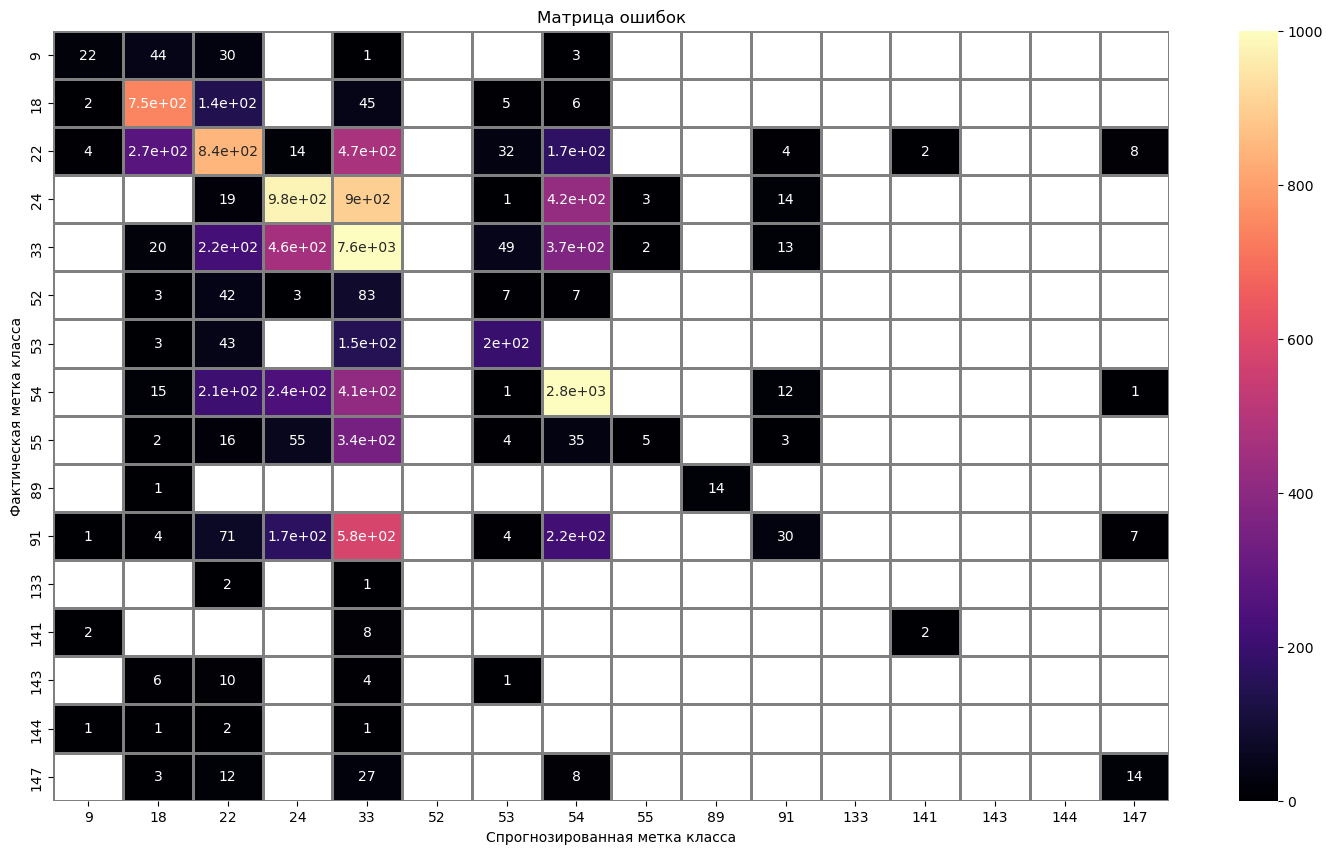

In [13]:
#визуализация производительности модели классификации
Confusion_matrix = confusion_matrix(y_test, prediction)
Confusion_matrix_df = pd.DataFrame(Confusion_matrix, range(16), range(16))
f, ax1 = plt.subplots(figsize=(18,10),nrows=1)
sns.heatmap(Confusion_matrix_df, annot=True, cmap='magma', ax=ax1, cbar=True, mask=Confusion_matrix_df<1, linewidth=0.8, linecolor='grey', square=False, vmin=0, vmax=1000, xticklabels=b, yticklabels=b)
ax1.set_title('Матрица ошибок')
ax1.set_xlabel('Спрогнозированная метка класса')
ax1.set_ylabel('Фактическая метка класса')

plt.show()

In [14]:
f1 = f1_score(prediction_new, y_new, average='weighted')
print(f'F1 score = {f1}')

F1 score = 0.6105869390220282
